In [6]:
!pip install neurokit2
!pip install py-ecg-detectors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
from ecgdetectors import Detectors


  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=fe9ac4eed27a69d526bf5a10457321cac6cb34901db2a55c149471100f9bea84
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\bb\49\5c\82f92e0ba9a437102b891c68367490fe9fca79df9075059e4e
Successfully built gatspy


Se carga el archivo y se conoce la estructura de los datos tanto filas como columnas

In [7]:
file_path = 'Diagnostics.xlsx'
df = pd.read_excel(file_path)

print("Columnas del DataFrame:")
print(df.columns.tolist())

print("Primeras filas del DataFrame:")
print(df.head())

print("\nColumnas del archivo:")
print(df.columns)

Columnas del DataFrame:
['FileName', 'Rhythm', 'Beat', 'PatientAge', 'Gender', 'VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset']
Primeras filas del DataFrame:
                     FileName Rhythm       Beat  PatientAge  Gender  \
0  MUSE_20180113_171327_27000   AFIB   RBBB TWC          85    MALE   
1  MUSE_20180112_073319_29000     SB        TWC          59  FEMALE   
2  MUSE_20180111_165520_97000     SA       NONE          20  FEMALE   
3  MUSE_20180113_121940_44000     SB       NONE          66    MALE   
4  MUSE_20180112_122850_57000     AF  STDD STTC          73  FEMALE   

   VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  RAxis  \
0              117         234          114         356          496     81   
1               52          52           92         432          401     76   
2               67          67           82         382          403     88   
3        

Conocer la cantidad de datos de nuestra base

In [8]:
#Estadisticas generales
print("\nResumen estadístico:")
print(df.describe(include='all'))
# Renombrar columnas si es necesario (ejemplo estándar)
# df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


Resumen estadístico:
                          FileName Rhythm   Beat    PatientAge Gender  \
count                        10646  10646  10646  10646.000000  10646   
unique                       10646     11    742           NaN      2   
top     MUSE_20180113_171327_27000     SB   NONE           NaN   MALE   
freq                             1   3889   5419           NaN   5956   
mean                           NaN    NaN    NaN     59.186831    NaN   
std                            NaN    NaN    NaN     18.030019    NaN   
min                            NaN    NaN    NaN      4.000000    NaN   
25%                            NaN    NaN    NaN     49.000000    NaN   
50%                            NaN    NaN    NaN     62.000000    NaN   
75%                            NaN    NaN    NaN     72.000000    NaN   
max                            NaN    NaN    NaN     98.000000    NaN   

        VentricularRate   AtrialRate   QRSDuration    QTInterval  \
count      10646.000000  10646.00

Arritmia mas prevalente


✅ Arritmias más prevalentes:
SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Rhythm, dtype: int64


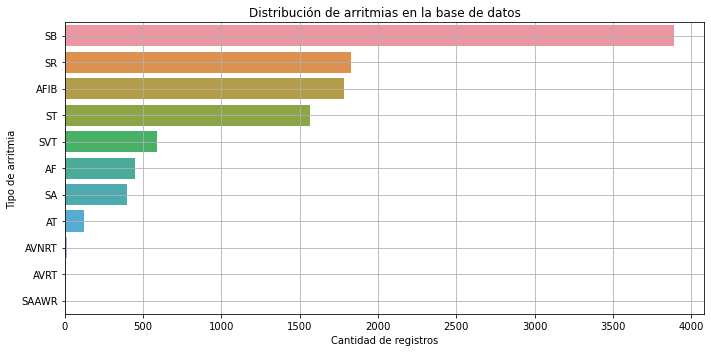

In [9]:
arritmia_col = 'Rhythm'  # Esta columna tiene los tipos de ritmo/arritmia
arritmias = df[arritmia_col].value_counts()

print("\n✅ Arritmias más prevalentes:")
print(arritmias)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, y=arritmia_col, order=arritmias.index)
plt.title("Distribución de arritmias en la base de datos")
plt.xlabel("Cantidad de registros")
plt.ylabel("Tipo de arritmia")
plt.grid(True)
plt.tight_layout()
plt.show()

Prevalencia de genero

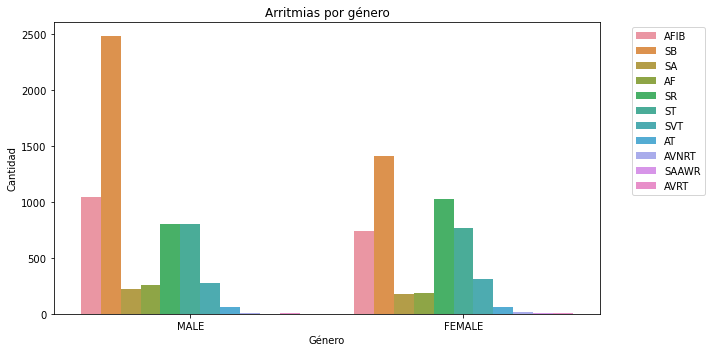

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Gender', hue=arritmia_col)
plt.title("Arritmias por género")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Prevalencia de edad

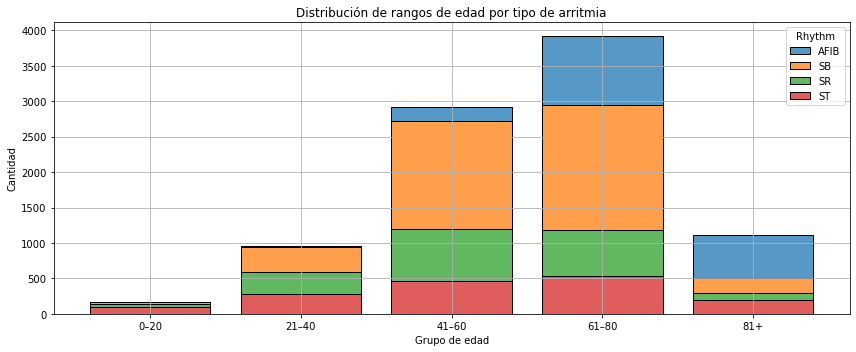

In [11]:
bins = [0, 20, 40, 60, 80, 120]
labels = ['0–20', '21–40', '41–60', '61–80', '81+']
df['AgeGroup'] = pd.cut(df['PatientAge'], bins=bins, labels=labels, right=False)

# Top 4 arritmias
arritmias = df[arritmia_col].value_counts()
top4_rhythms = arritmias.head(4).index.tolist()

# Filtrar dataframe para solo las 4 arritmias
df_top4 = df[df[arritmia_col].isin(top4_rhythms)]

# Plot usando grupos de edad
plt.figure(figsize=(12, 5))
sns.histplot(
    data=df_top4,
    x='AgeGroup',
    hue=arritmia_col,
    multiple="stack",
    shrink=0.8,
    discrete=True  # Muy importante para que trate AgeGroup como categorías, no como continuo
)
plt.title("Distribución de rangos de edad por tipo de arritmia")
plt.xlabel("Grupo de edad")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print("\nDistribución de edades:")
print(df['PatientAge'].describe())


Distribución de edades:
count    10646.000000
mean        59.186831
std         18.030019
min          4.000000
25%         49.000000
50%         62.000000
75%         72.000000
max         98.000000
Name: PatientAge, dtype: float64


¿Qué datos se pueden usar para entrenar modelos?

In [13]:
# Calcular las 4 arritmias más frecuentes
arritmias = df['Rhythm'].value_counts()
top4_rhythms = arritmias.head(4).index.tolist()

# Definir los intervalos de edad
bins = [0, 20, 40, 60, 80, 120]
labels = ['0–20', '21–40', '41–60', '61–80', '81+']
df['AgeGroup'] = pd.cut(df['PatientAge'], bins=bins, labels=labels)

# Filtrar solo las arritmias más comunes
df_top4 = df[df['Rhythm'].isin(top4_rhythms)]

# Contar cuántos registros hay por grupo de edad y arritmia
age_rhythm_distribution = df_top4.groupby(['AgeGroup', 'Rhythm']).size().unstack(fill_value=0)

# Mostrar resultados
print("Distribución de las 4 arritmias más comunes por rango de edad:")
print(age_rhythm_distribution)

print(f"\nSe recomienda enfocarse en estos rangos de edad con más registros:")
print(df['AgeGroup'].value_counts().sort_index().to_string())

print(f"\nY en estas arritmias más comunes: {top4_rhythms}")


Distribución de las 4 arritmias más comunes por rango de edad:
Rhythm    AFIB    SB   SR   ST
AgeGroup                      
0–20         0    40   36  117
21–40       10   364  335  277
41–60      218  1639  751  474
61–80     1022  1664  613  532
81+        530   182   91  168

Se recomienda enfocarse en estos rangos de edad con más registros:
0–20      359
21–40    1231
41–60    3478
61–80    4395
81+      1183

Y en estas arritmias más comunes: ['SB', 'SR', 'AFIB', 'ST']


- Al entrenar modelos, es importante contar con una cantidad suficiente de datos por categoría para evitar sesgos.
- Los grupos de edad con más registros permiten entrenar modelos más robustos y generalizables.
- Además, según los análisis anteriores, estas arritmias aparecen como las más prevalentes tanto en general como en los distintos géneros y grupos de edad, por lo que son relevantes clínicamente.

- Aunque el género muestra ciertas diferencias en tipos de arritmia, no es tan determinante como la edad y las variables fisiológicas."
- Es más efectivo seleccionar grupos etarios bien representados y centrarse en arritmias comunes.
- Un análisis de importancia de variables puede confirmar qué atributos tienen mayor poder predictivo."
- Si en el futuro se encuentran diferencias clínicas marcadas por género, se puede entrenar un modelo separado para cada uno.


Distribución porcentual de arritmias por género:

Rhythm   AF  AFIB   AT  AVNRT  AVRT   SA  SAAWR    SB    SR    ST  SVT
Gender                                                                
FEMALE  4.0  15.8  1.2    0.3   0.1  3.8    0.1  30.0  21.8  16.4  6.6
MALE    4.3  17.5  1.1    0.1   0.1  3.7    0.0  41.7  13.5  13.4  4.7


<Figure size 720x432 with 0 Axes>

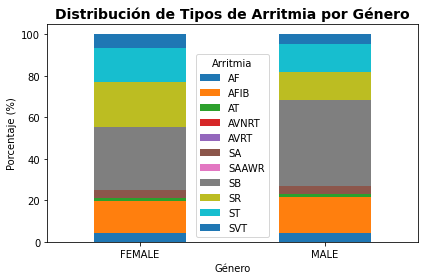


Distribución porcentual de arritmias por grupo de edad:

Rhythm     AF  AFIB   AT  AVNRT  AVRT    SA  SAAWR    SB    SR    ST  SVT
AgeGroup                                                                 
0–20      0.0   0.0  1.7    0.0   0.0  39.8    0.6  11.1  10.0  32.6  4.2
21–40     1.1   0.8  0.6    0.2   0.1   8.9    0.1  29.6  27.2  22.5  8.9
41–60     2.2   6.3  0.5    0.2   0.1   2.1    0.0  47.1  21.6  13.6  6.4
61–80     5.6  23.3  1.5    0.1   0.1   1.5    0.0  37.9  13.9  12.1  4.1
81+       9.5  44.8  1.9    0.3   0.0   0.7    0.2  15.4   7.7  14.2  5.4


<Figure size 864x504 with 0 Axes>

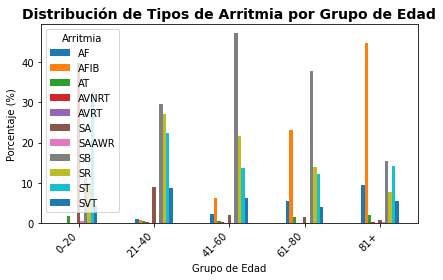

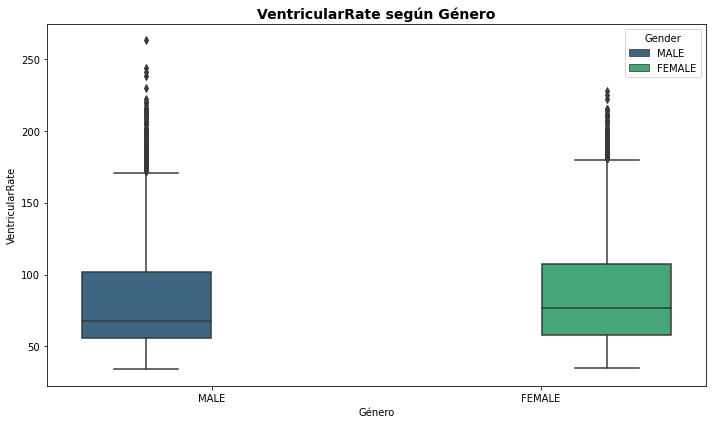

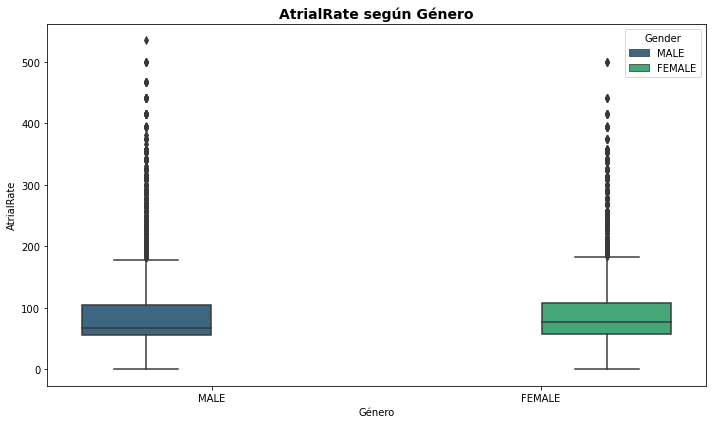

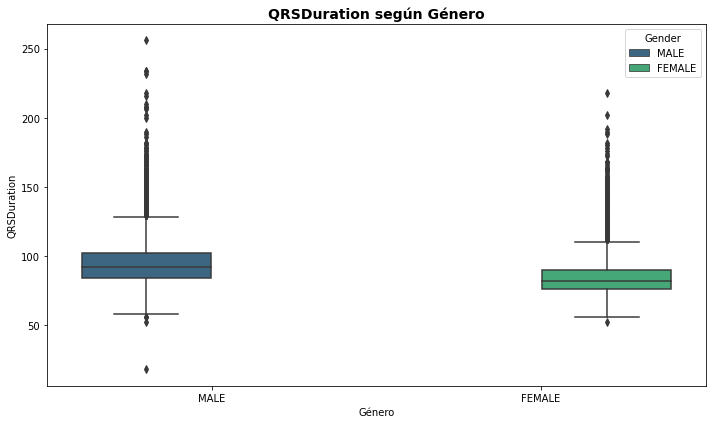

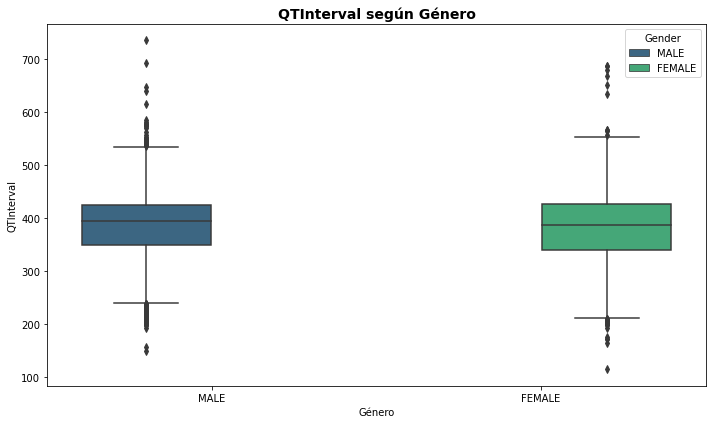

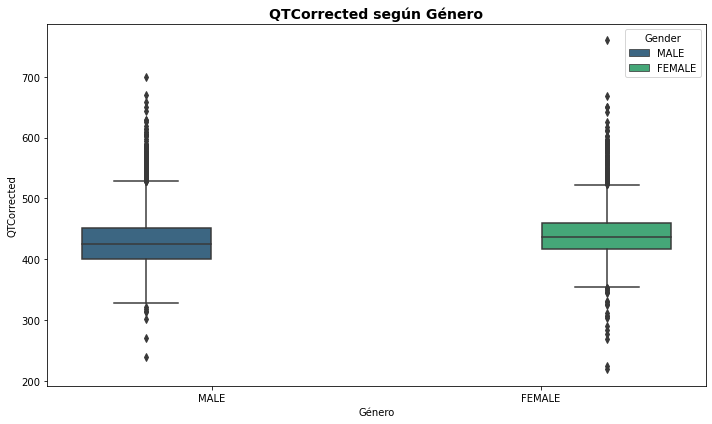

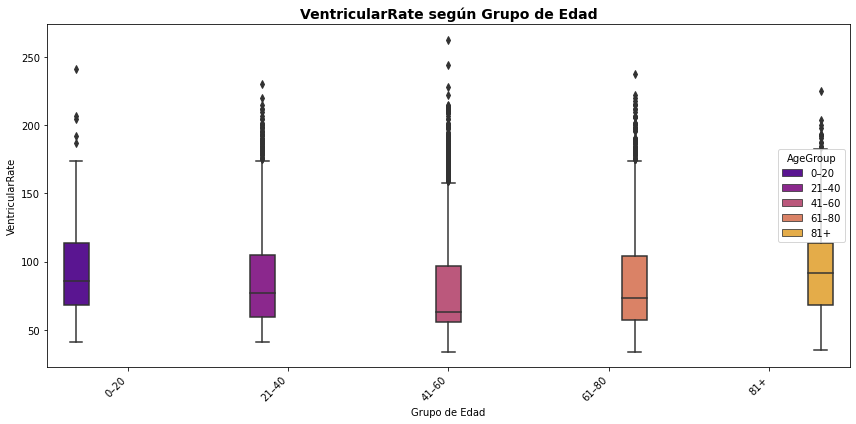

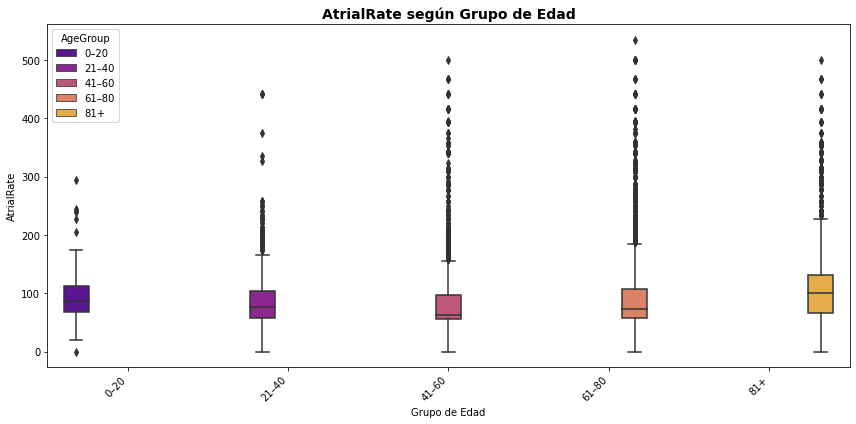

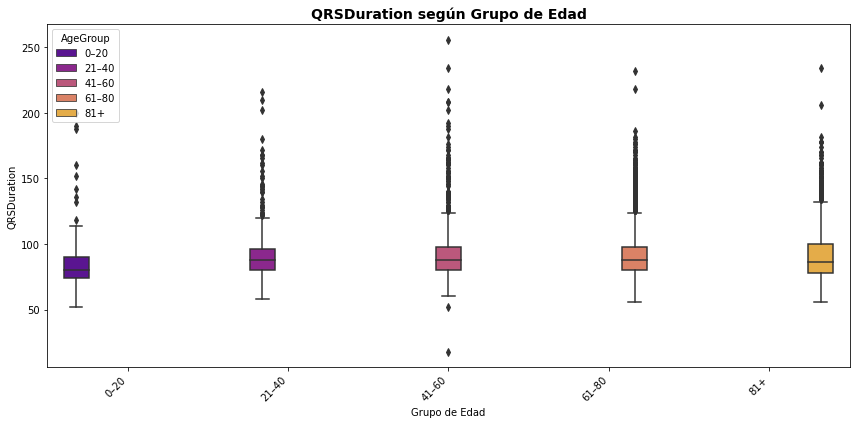

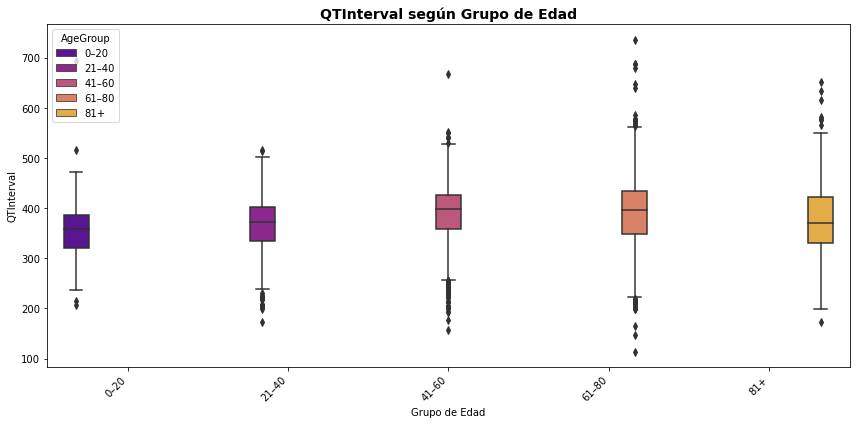

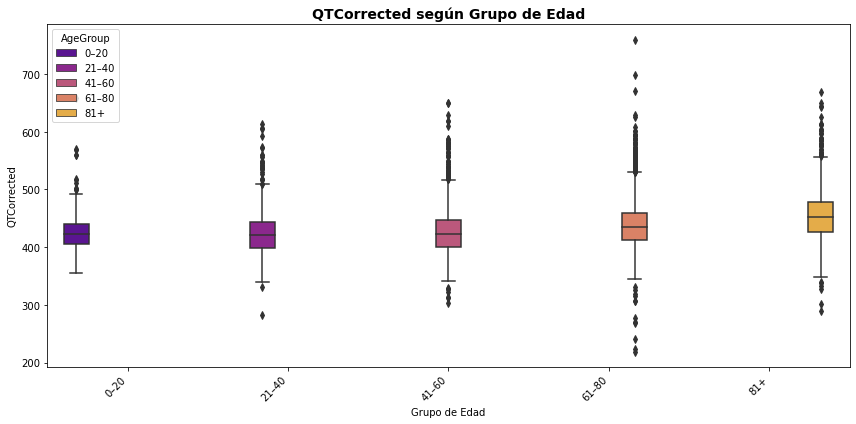


Correlación entre variables fisiológicas:


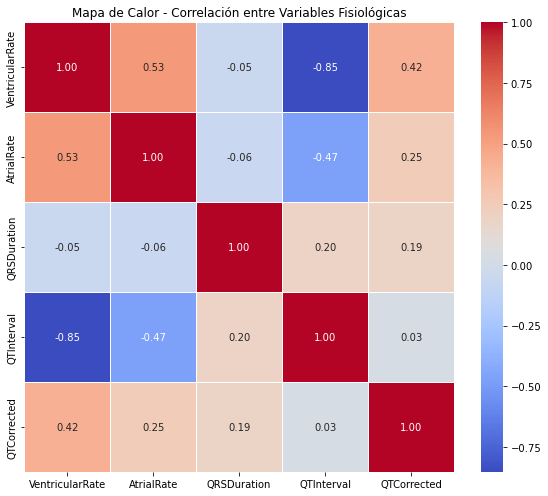

In [19]:
# Variables fisiológicas a analizar
fisiologicas = ['VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected']

# --- 1. Distribución de tipos de arritmia según el género ---
tabla_genero_arritmia = pd.crosstab(df['Gender'], df['Rhythm'])
porcentaje_genero = tabla_genero_arritmia.div(tabla_genero_arritmia.sum(axis=1), axis=0) * 100

print("\nDistribución porcentual de arritmias por género:\n")
print(porcentaje_genero.round(1).to_string())

# Visualización
plt.figure(figsize=(10, 6))
porcentaje_genero.plot(kind='bar', stacked=True)
plt.title("Distribución de Tipos de Arritmia por Género", fontsize=14, fontweight='bold')
plt.xlabel("Género")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)
plt.legend(title='Arritmia')
plt.tight_layout()
plt.show()

# --- 2. Distribución de tipos de arritmia según grupo etario ---
tabla_edad_arritmia = pd.crosstab(df['AgeGroup'], df['Rhythm'])
porcentaje_edad = tabla_edad_arritmia.div(tabla_edad_arritmia.sum(axis=1), axis=0) * 100

print("\nDistribución porcentual de arritmias por grupo de edad:\n")
print(porcentaje_edad.round(1).to_string())

# Visualización
plt.figure(figsize=(12, 7))
porcentaje_edad.plot(kind='bar')
plt.title("Distribución de Tipos de Arritmia por Grupo de Edad", fontsize=14, fontweight='bold')
plt.xlabel("Grupo de Edad")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Arritmia')
plt.tight_layout()
plt.show()

# --- 3. Análisis de variables fisiológicas por género ---
for variable in fisiologicas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Gender', y=variable, hue='Gender', palette='viridis')
    plt.title(f"{variable} según Género", fontsize=14, fontweight='bold')
    plt.xlabel("Género")
    plt.ylabel(variable)
    plt.tight_layout()
    plt.show()

# --- 4. Análisis de variables fisiológicas por grupo etario ---
for variable in fisiologicas:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='AgeGroup', y=variable, hue='AgeGroup', palette='plasma')
    plt.title(f"{variable} según Grupo de Edad", fontsize=14, fontweight='bold')
    plt.xlabel("Grupo de Edad")
    plt.ylabel(variable)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- 5. Mapa de calor de correlación entre variables fisiológicas ---
print("\nCorrelación entre variables fisiológicas:")

plt.figure(figsize=(8, 7))
correlaciones = df[fisiologicas].corr()
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor - Correlación entre Variables Fisiológicas")
plt.tight_layout()
plt.show()

Analisis 2

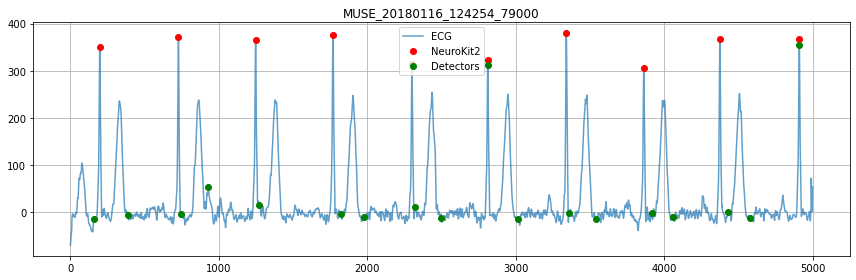

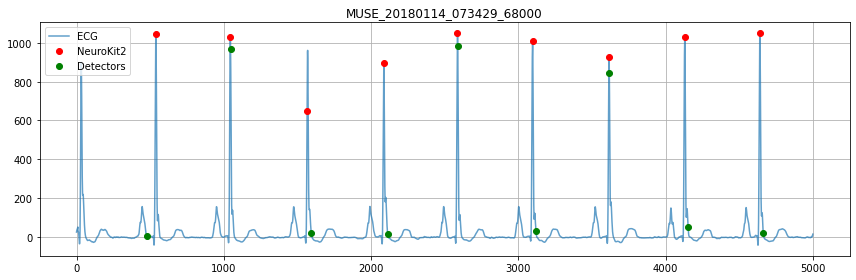

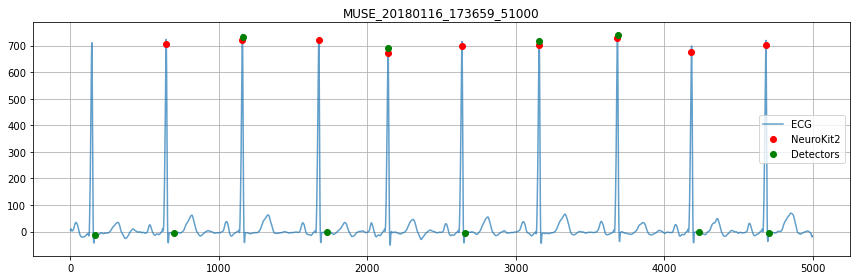

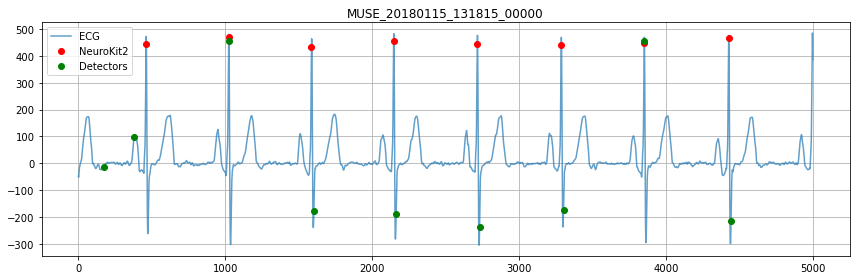

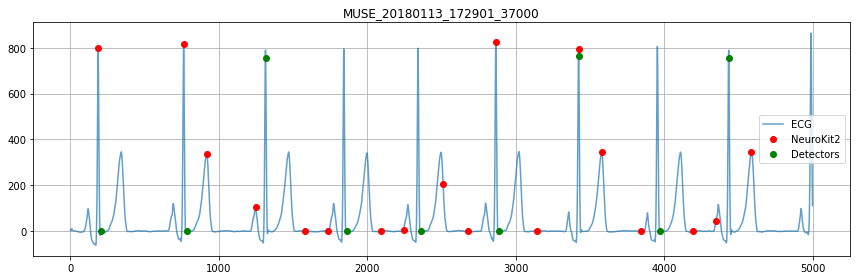

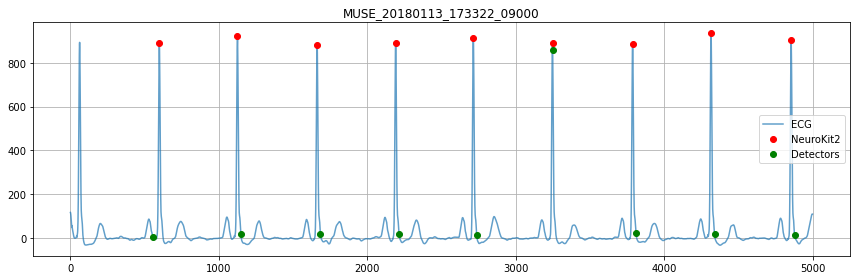

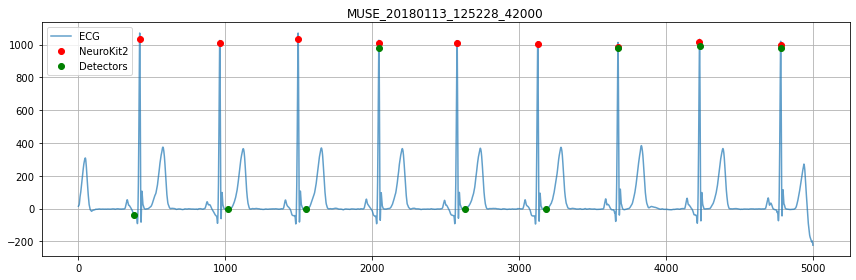

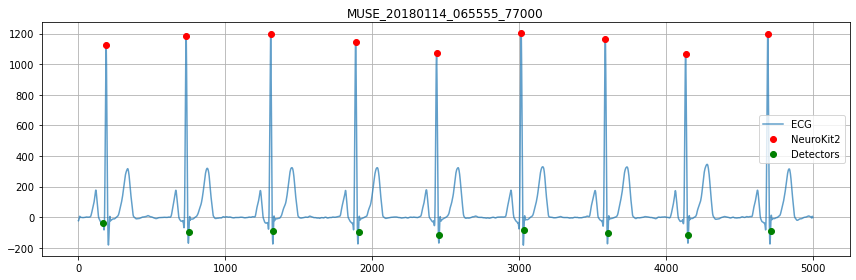

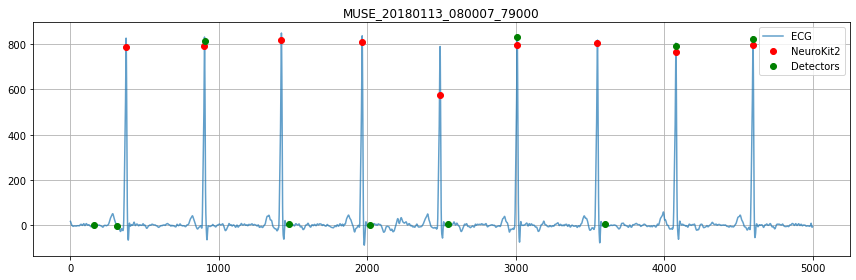

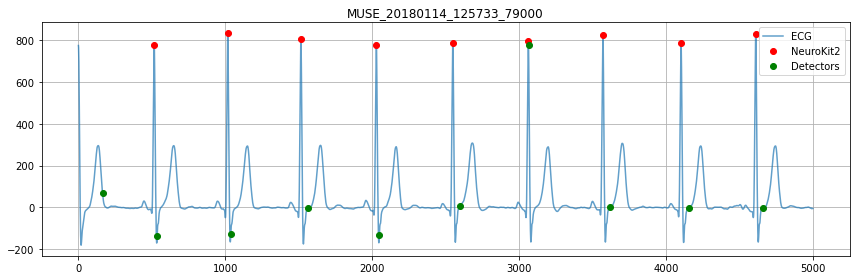

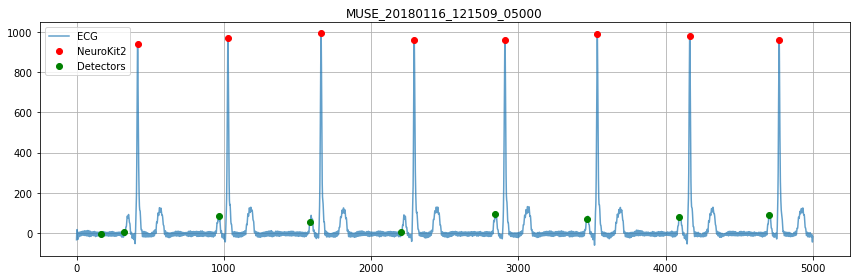

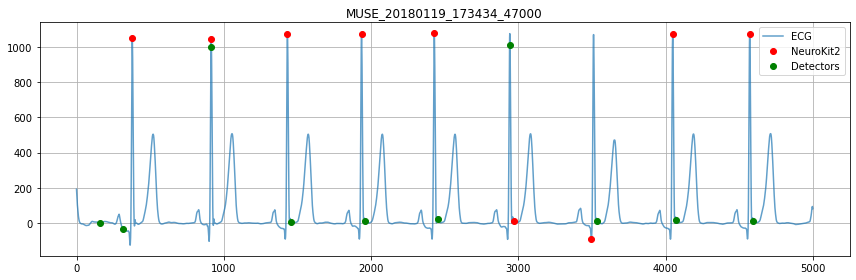

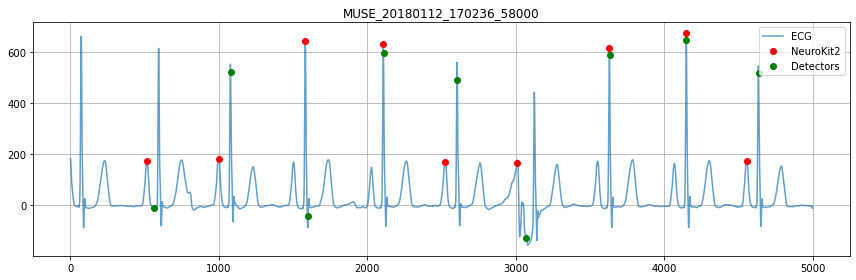

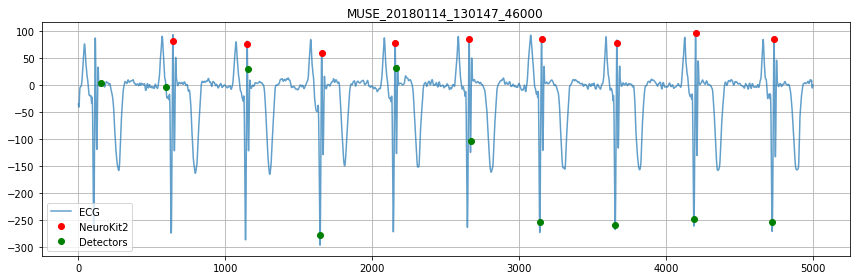

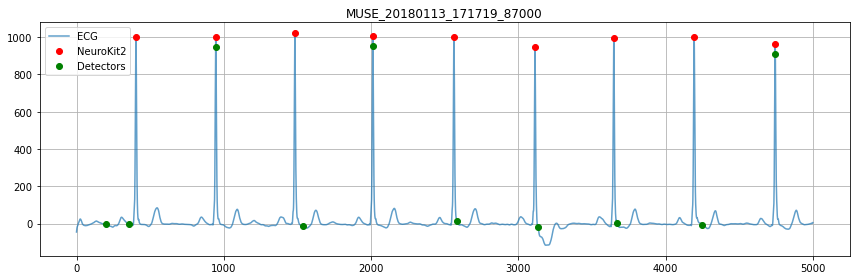

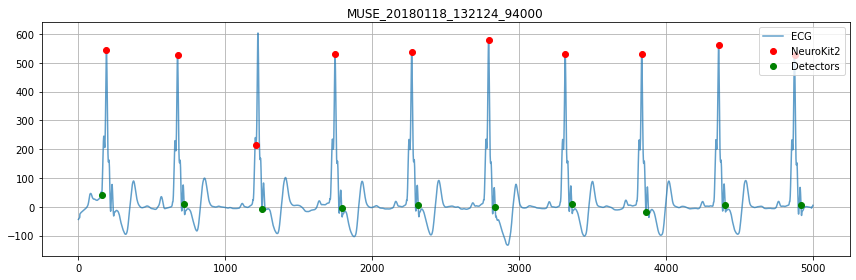

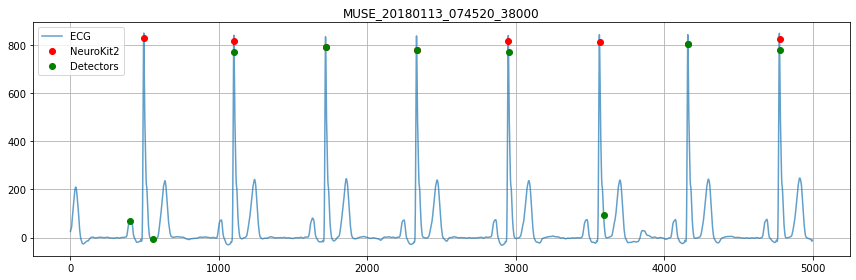

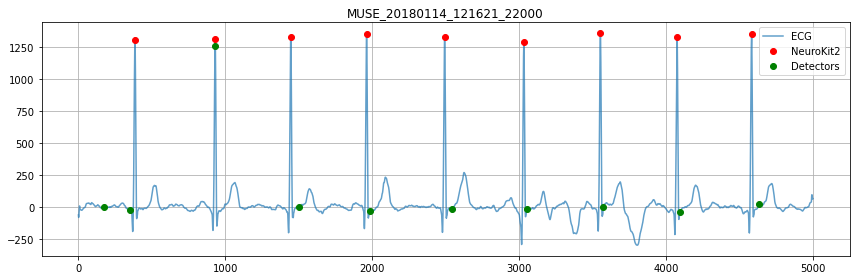

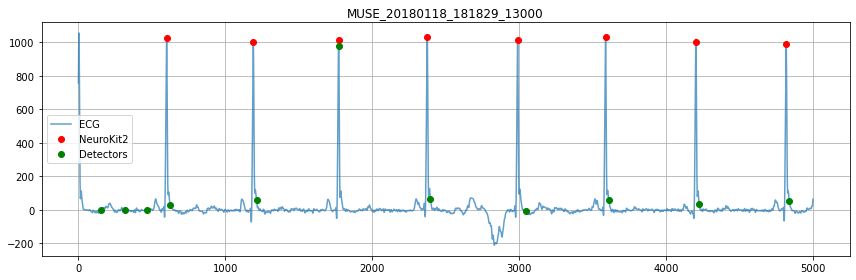

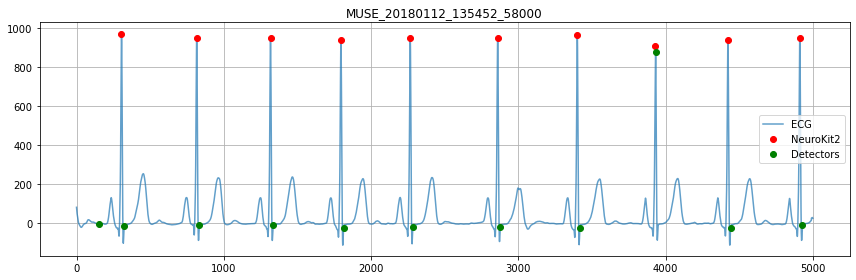

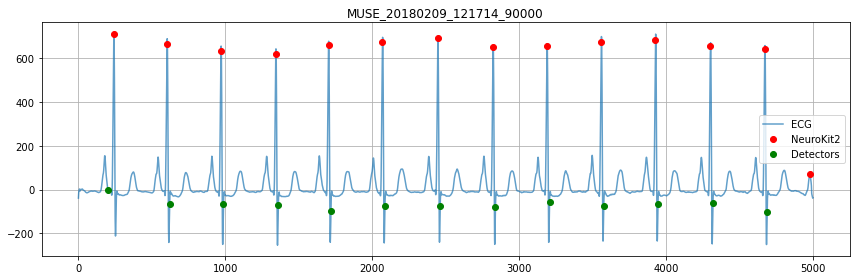

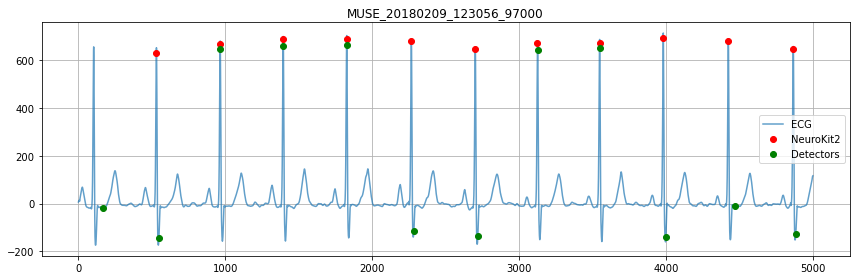

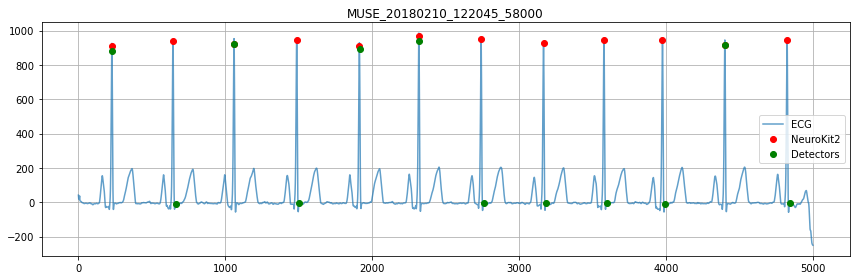

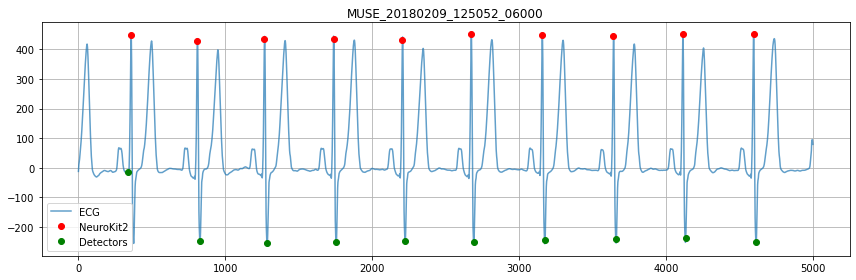

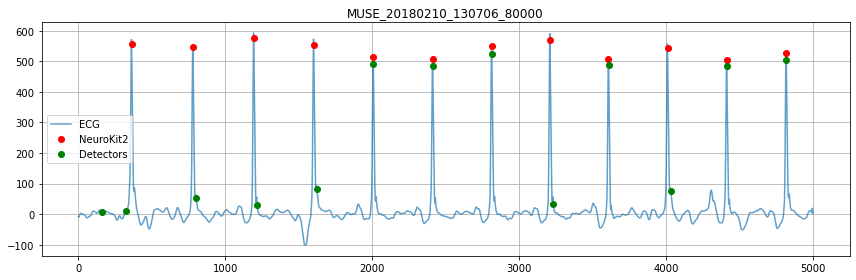

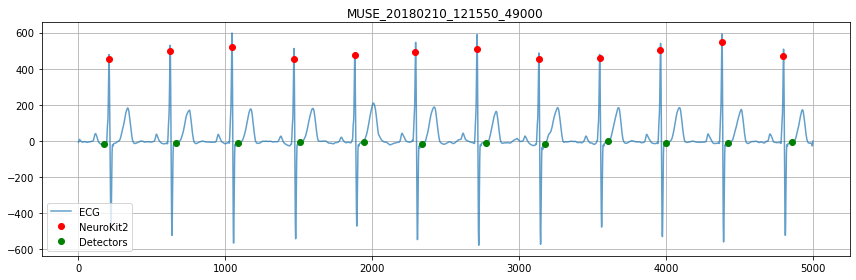

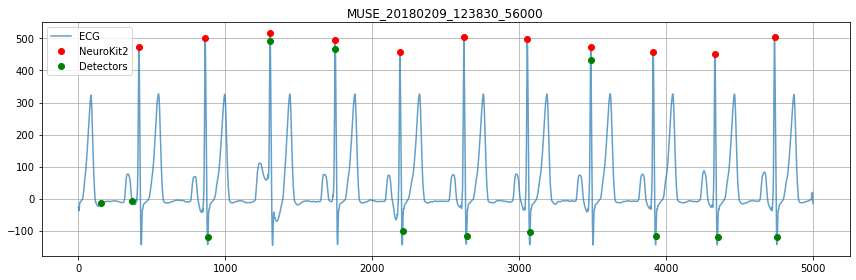

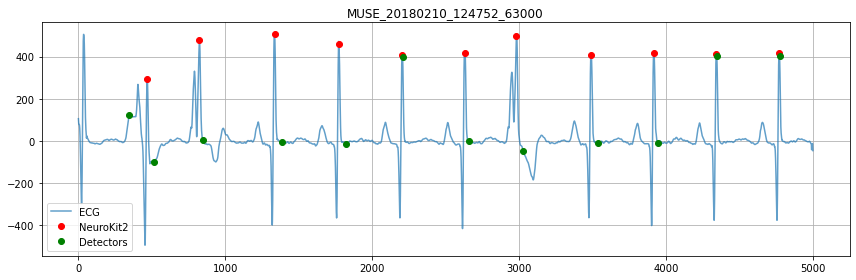

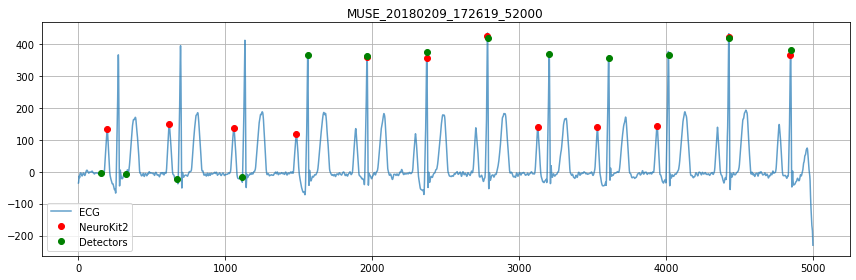

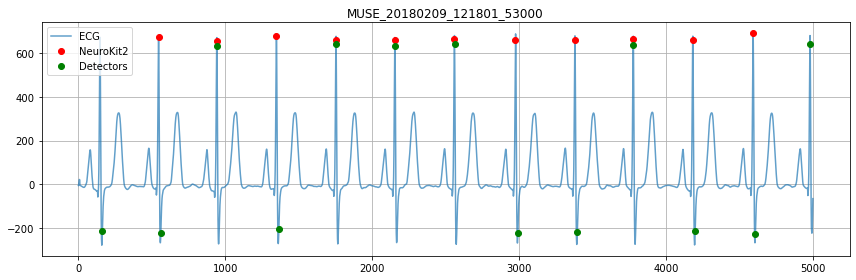

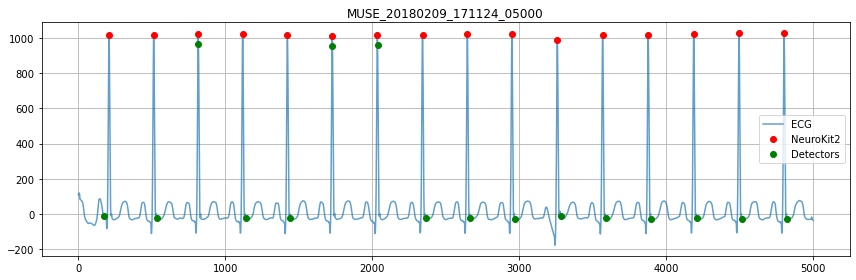

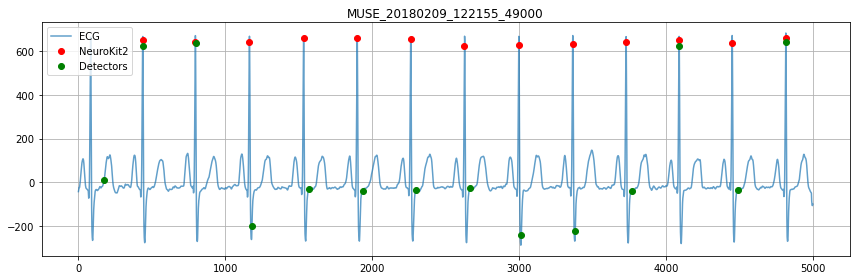

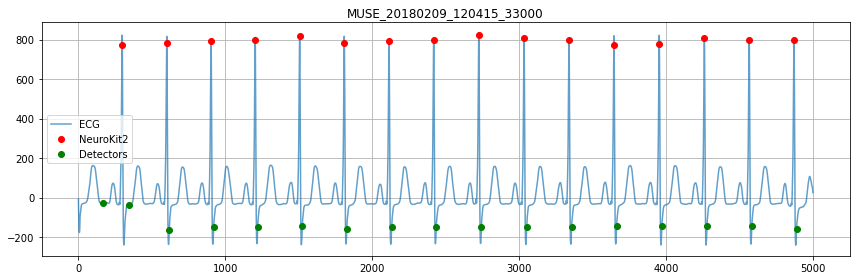

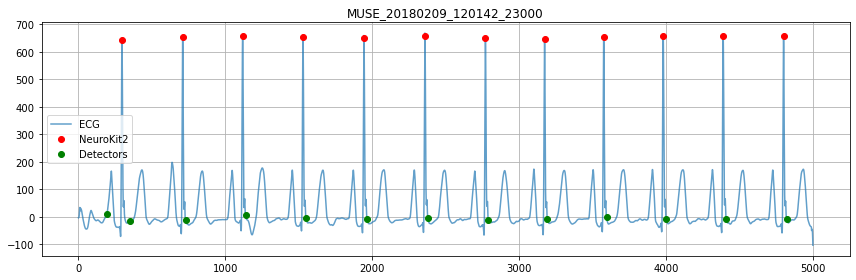

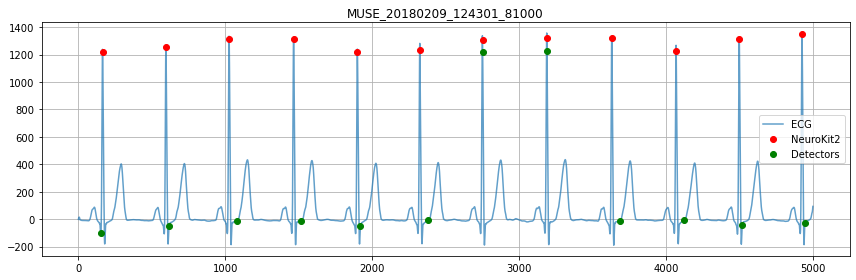

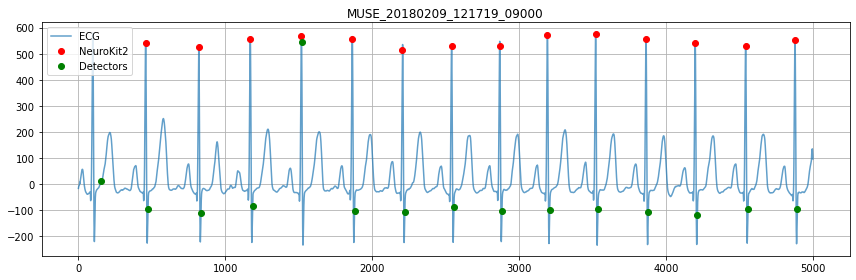

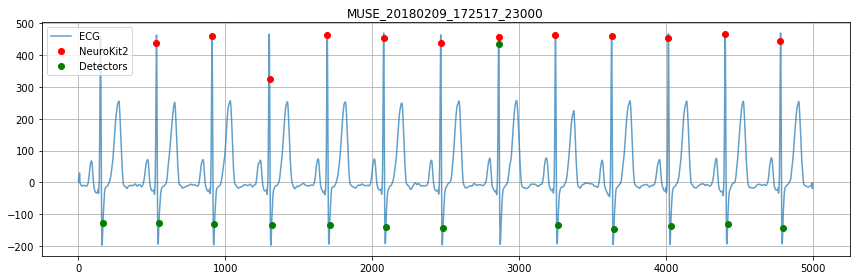

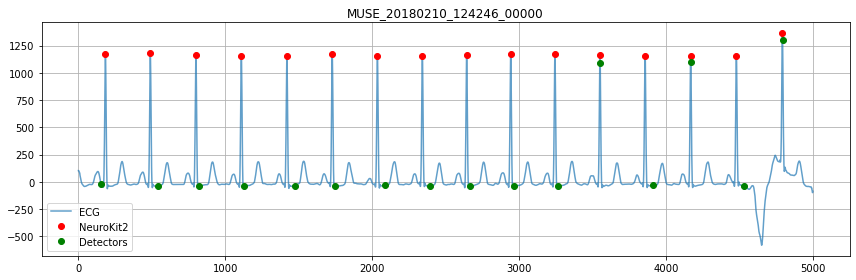

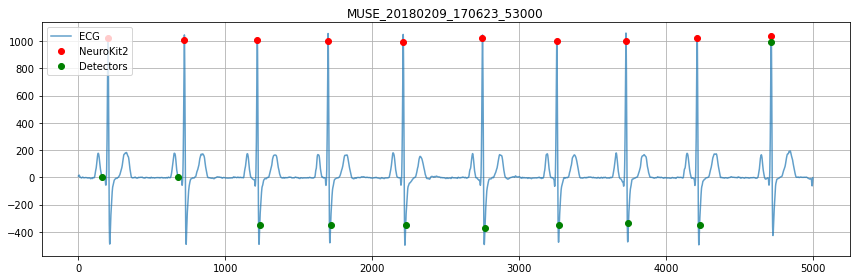

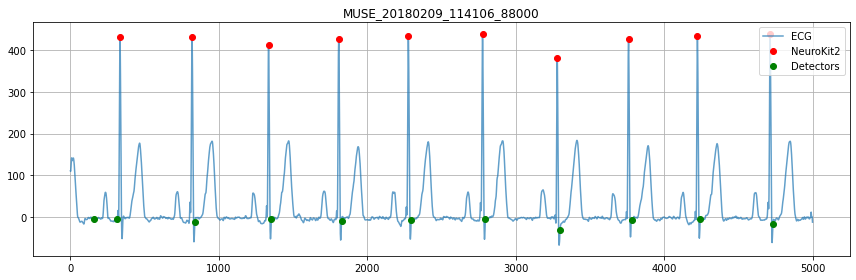


 Resultados guardados en 'resultados_SB_SR.xlsx'
                       Archivo Arritmia  Picos_NK  BPM_NK  Picos_DET  BPM_DET
0   MUSE_20180116_124254_79000       SB        10    60.0         18    108.0
1   MUSE_20180114_073429_68000       SB         9    54.0          9     54.0
2   MUSE_20180116_173659_51000       SB         9    54.0         10     60.0
3   MUSE_20180115_131815_00000       SB         8    48.0          9     54.0
4   MUSE_20180113_172901_37000       SB        18   108.0          9     54.0
5   MUSE_20180113_173322_09000       SB         9    54.0          9     54.0
6   MUSE_20180113_125228_42000       SB         9    54.0          9     54.0
7   MUSE_20180114_065555_77000       SB         9    54.0          9     54.0
8   MUSE_20180113_080007_79000       SB         9    54.0         10     60.0
9   MUSE_20180114_125733_79000       SB         9    54.0         10     60.0
10  MUSE_20180116_121509_05000       SB         8    48.0          9     54.0
11  MUSE_20180

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from ecgdetectors import Detectors

# 1. Crear subconjunto con SB y SR
def crear_subconjunto(df):
    sb_samples = df[df['Rhythm'] == 'SB'].sample(n=20, random_state=42)
    sr_samples = df[df['Rhythm'] == 'SR'].sample(n=20, random_state=42)
    subset_df = pd.concat([sb_samples, sr_samples]).reset_index(drop=True)
    return subset_df

# 3. Procesador de ECG
class ECGProcessor:
    def __init__(self, data_dir="ECGDataDenoised", fs=500):
        self.fs = fs
        self.data_dir = data_dir
        self.detectors = Detectors(fs)

    def cargar_archivo(self, nombre_archivo):
        ruta = os.path.join(self.data_dir, f"{nombre_archivo}.csv")
        if not os.path.exists(ruta):
            print(f"Archivo no encontrado: {ruta}")
            return None
        try:
            df = pd.read_csv(ruta)
            return df.iloc[:, 1].values
        except Exception as e:
            print(f"Error leyendo {nombre_archivo}: {str(e)}")
            return None

    def detectar_picos(self, señal):
        try:
            _, nk_info = nk.ecg_process(señal, sampling_rate=self.fs)
            picos_nk = nk_info["ECG_R_Peaks"]
        except:
            picos_nk = np.array([])
        try:
            picos_det = self.detectors.pan_tompkins_detector(señal)
        except:
            picos_det = np.array([])
        return picos_nk, picos_det

    def calcular_bpm(self, picos, duracion):
        return len(picos) * 60 / (duracion / self.fs) if len(picos) >= 2 else 0

# 4. Gráfico
def graficar_ecg(señal, picos_nk, picos_det, nombre_archivo):
    plt.figure(figsize=(12, 4))
    plt.plot(señal, alpha=0.7, label="ECG")
    if len(picos_nk) > 0:
        plt.plot(picos_nk, señal[picos_nk], 'ro', label="NeuroKit2")
    if len(picos_det) > 0:
        plt.plot(picos_det, señal[picos_det], 'go', label="Detectors")
    plt.title(nombre_archivo)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Función principal
def main():
    # Configura tus rutas
    metadata_file = "Diagnostics.xlsx"
    subconjunto_file = "subconjunto_SB_SR.xlsx"
    carpeta_datos = "ECGDataDenoised"

    # Crear subconjunto si no existe
    df = pd.read_excel(metadata_file)
    subset_df = crear_subconjunto(df)
    subset_df['FileName'] = subset_df['FileName'].apply(lambda x: os.path.basename(str(x)).replace('\\', '/').replace('.csv', ''))
    subset_df.to_excel(subconjunto_file, index=False)

    # Procesar
    procesador = ECGProcessor(data_dir=carpeta_datos, fs=500)
    resultados = []

    for i, fila in subset_df.iterrows():
        nombre = fila['FileName']
        señal = procesador.cargar_archivo(nombre)
        if señal is None:
            continue
        picos_nk, picos_det = procesador.detectar_picos(señal)
        bpm_nk = procesador.calcular_bpm(picos_nk, len(señal))
        bpm_det = procesador.calcular_bpm(picos_det, len(señal))

        resultados.append({
            "Archivo": nombre,
            "Arritmia": fila['Rhythm'],
            "Picos_NK": len(picos_nk),
            "BPM_NK": round(bpm_nk, 1),
            "Picos_DET": len(picos_det),
            "BPM_DET": round(bpm_det, 1)
        })

        graficar_ecg(señal, picos_nk, picos_det, nombre)

    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_excel("resultados_SB_SR.xlsx", index=False)
    print("\n Resultados guardados en 'resultados_SB_SR.xlsx'")
    print(df_resultados)

if __name__ == "__main__":
    main()

In [ ]:
df = pd.read_excel("Diagnostics.xlsx")

# Normaliza los nombres de archivo
df["FileName"] = df["FileName"].apply(lambda x: os.path.splitext(os.path.basename(str(x).replace("\\", "/")))[0])

# Archivos disponibles
available_files = os.listdir("ECGDataDenoised")
available_files = [os.path.splitext(f)[0] for f in available_files if f.endswith(".csv")]

# Filtrar solo registros con archivos existentes
df = df[df["FileName"].isin(available_files)]

# Elegir 20 registros de cada arritmia
df_sb = df[df["Rhythm"] == "SB"].sample(n=20, random_state=42)
df_sr = df[df["Rhythm"] == "SR"].sample(n=20, random_state=42)
subset_df = pd.concat([df_sb, df_sr]).reset_index(drop=True)

# Guardar
subset_df.to_excel("subconjunto_SB_SR_filtrado.xlsx", index=False)

✅ Archivo 'subconjunto_SB_SR_filtrado.xlsx' creado exitosamente.


In [ ]:

!pip install fpdf

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from ecgdetectors import Detectors
from fpdf import FPDF

# Crear clase personalizada para PDF
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, "Análisis de Picos R - Arritmias SB y SR", ln=True, align="C")
        self.ln(5)

    def add_plot(self, img_path, title=""):
        self.add_page()
        self.set_font("Arial", "", 10)
        self.cell(0, 10, title, ln=True)
        self.image(img_path, x=10, y=25, w=190)

# Funciones
class ECGProcessor:
    def __init__(self, data_dir="ECGDataDenoised", fs=500):
        self.fs = fs
        self.data_dir = data_dir
        self.detectors = Detectors(fs)

    def cargar_archivo(self, nombre_archivo):
        path = os.path.join(self.data_dir, f"{nombre_archivo}.csv")
        if not os.path.exists(path):
            return None
        df = pd.read_csv(path)
        return df.iloc[:, 1].values

    def detectar_picos(self, senal):
        try:
            _, nk_info = nk.ecg_process(senal, sampling_rate=self.fs)
            r_nk = nk_info["ECG_R_Peaks"]
        except:
            r_nk = []
        try:
            r_det = self.detectors.pan_tompkins_detector(senal)
        except:
            r_det = []
        return r_nk, r_det

    def calcular_bpm(self, picos, duracion):
        return len(picos) * 60 / (duracion / self.fs) if len(picos) >= 2 else 0

def graficar_ecg(senal, picos_nk, picos_det, nombre_archivo):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(senal, label="ECG", alpha=0.6)
    if len(picos_nk) > 0:
        ax.plot(picos_nk, senal[picos_nk], "ro", label="NeuroKit2")
    if len(picos_det) > 0:
        ax.plot(picos_det, senal[picos_det], "go", label="Detectors")
    ax.set_title(nombre_archivo)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    img_path = f"plots/{nombre_archivo}.png"
    plt.savefig(img_path)
    plt.close()
    return img_path

def main():
    os.makedirs("plots", exist_ok=True)
    pdf = PDF()
    procesador = ECGProcessor()
    subset_df = pd.read_excel("subconjunto_SB_SR_filtrado.xlsx")
    resultados = []

    for i, fila in subset_df.iterrows():
        nombre = os.path.splitext(os.path.basename(str(fila['FileName'])))[0]
        ritmo = fila["Rhythm"]
        senal = procesador.cargar_archivo(nombre)
        if senal is None:
            continue

        p_nk, p_det = procesador.detectar_picos(senal)
        bpm_nk = procesador.calcular_bpm(p_nk, len(senal))
        bpm_det = procesador.calcular_bpm(p_det, len(senal))

        resultados.append({
            "Archivo": nombre,
            "Arritmia": ritmo,
            "Picos_NK": len(p_nk),
            "BPM_NK": round(bpm_nk, 1),
            "Picos_DET": len(p_det),
            "BPM_DET": round(bpm_det, 1)
        })

        img_path = graficar_ecg(senal, p_nk, p_det, nombre)
        pdf.add_plot(img_path, title=f"{nombre} - {ritmo}")

    # Guardar DataFrame
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_excel("resultados_SB_SR.xlsx", index=False)

    # Agregar resumen al PDF
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Resumen de Resultados", ln=True)
    pdf.ln(5)
    pdf.set_font("Arial", "", 10)
    for i, row in df_resultados.iterrows():
        linea = f"{row['Archivo']}: NK = {row['BPM_NK']} bpm | DET = {row['BPM_DET']} bpm"
        pdf.cell(0, 8, linea, ln=True)

    pdf.output("analisis_ecg_SB_SR.pdf")
    print(" PDF generado: analisis_ecg_SB_SR.pdf")

if __name__ == "__main__":
    main()


✅ PDF generado: analisis_ecg_SB_SR.pdf


Punto 3

In [ ]:

import os
import pandas as pd
import numpy as np
import neurokit2 as nk
from hrvanalysis import get_time_domain_features

# 1. Cargar subconjunto utilizado en Análisis 1
df = pd.read_excel("subconjunto_SB_SR_filtrado.xlsx")

# 2. Preparar carpeta con los archivos .csv
carpeta = "ECGDataDenoised"
sampling_rate = 500

# 3. Inicializar resultados
resultados_hrv = []

# 4. Procesar cada archivo usando NEUROKIT (mejor método según Análisis 2)
for i, fila in df.iterrows():
    nombre = os.path.splitext(os.path.basename(str(fila['FileName'])))[0]
    ruta = os.path.join(carpeta, f"{nombre}.csv")

    if not os.path.exists(ruta):
        print(f"❌ No encontrado: {ruta}")
        continue

    try:
        data = pd.read_csv(ruta)
        senal = data.iloc[:, 1].values

        # Detectar picos R con NeuroKit
        _, info = nk.ecg_process(senal, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        # Calcular intervalos RR (en milisegundos)
        rr_intervals = np.diff(r_peaks) * (1000 / sampling_rate)

        # Extraer características de HRV (dominio del tiempo)
        time_features = get_time_domain_features(rr_intervals)

        # Agregar metadatos
        time_features["Archivo"] = nombre
        time_features["Arritmia"] = fila["Rhythm"]
        resultados_hrv.append(time_features)

    except Exception as e:
        print(f" Error en {nombre}: {str(e)}")

# 5. Guardar resultados
df_hrv = pd.DataFrame(resultados_hrv)
df_hrv.to_excel("hrv_resultados_SB_SR.xlsx", index=False)
print(" Análisis de HRV completado y exportado a 'hrv_resultados_SB_SR.xlsx'")


 Análisis de HRV completado y exportado a 'hrv_resultados_SB_SR.xlsx'


Analisis propuesto
1. Nuestras arritmias escogidas fueron Sb y Sr para una comparaión de su HRV Se comparan características como SDNN y RMSSD entre los grupos usando la prueba de Mann-Whitney. dado que los datos no son normales.
2.Cálculo de características en el dominio de la frecuencia: se calcularon en el paso anterior con get_frequency_domain_features 
3. Entropía y complejidad: con la función get_nonlinear_features, que incluye características como la entropía.
4. Clasificación usando características de HRV: Se entrenó un modelo de clasificación usando Random Forest, utilizando las características de HRV como entradas. Se calcula la precisión del modelo en un conjunto de prueba.
5. Visualización: Se crean boxplots para comparar las distribuciones de características como SDNN y RMSSD entre los grupos SB y SR.

Se genera una matriz de correlación para observar cómo se relacionan las diferentes características de HRV.

Calcular dos características no lineales relacionadas con la variabilidad de la frecuencia cardíaca (HRV) a partir de los intervalos RR (el tiempo entre los picos R sucesivos en el ECG):
1.Entropía de Shannon:La entropía de Shannon es una medida de la incertidumbre o aleatoriedad de un conjunto de datos. En el contexto de HRV, nos ayuda a entender la complejidad de los intervalos RR. Si los intervalos RR son muy predecibles y regulares, la entropía será baja. Si los intervalos son más impredecibles o caóticos, la entropía será más alta.
la función shannon_entropy(rr_intervals):

Entrada: Un arreglo de intervalos RR (rr_intervals), que son los tiempos entre picos R consecutivos del ECG.

Proceso:
Utiliza np.histogram para calcular el histograma de los intervalos RR, dividiendo los valores en 20 bins (contenedores).
Se normaliza el histograma, dividiendo entre la suma de los valores.
Se eliminan los valores de histograma que son 0 para evitar problemas en los cálculos.
Luego, se calcula la entropía usando la fórmula de Shannon: 
H=−∑p(x)⋅log(p(x)) donde 
p(x) es la probabilidad de los intervalos RR en cada bin.

Salida: La entropía (un número que refleja la incertidumbre en los intervalos RR).
on un valor de 0.7396, los intervalos RR parecen tener una cantidad moderada de irregularidad, lo que indica que la señal tiene cierta complejidad pero no es extremadamente caótica. Esto podría indicar un comportamiento relativamente estable con alguna variabilidad, lo que es común en el análisis de HRV.

2.Aproximación de la Dimensión Fractal (ApEn):El ApEn es una medida de la complejidad dinámica de una señal. En HRV, nos indica cuán predecible es la secuencia de intervalos RR. Un ApEn bajo sugiere que la secuencia de intervalos es más predecible, mientras que un ApEn alto sugiere mayor complejidad y menor previsibilidad.
Explicación de la función approximate_entropy(rr_intervals, m=2, r=0.2):

Entrada: Un arreglo de intervalos RR y dos parámetros opcionales m y r.

Proceso:
Se crea una matriz X que contiene sub-secuencias de tamaño m de los intervalos RR.
Se calcula una matriz de similaridad 
C que compara todas las sub-secuencias entre sí. Si la distancia entre dos sub-secuencias es menor que el umbral 
r, se considera que son similares.
Se calcula la función 

ϕ(m,r), que es la probabilidad de que dos sub-secuencias sean similares. Luego, se calcula 

ϕ(m+1,r) y el ApEn se define como el logaritmo de la razón entre estos dos valores:

ApEn(m,r)=log( ϕ(m+1,r)/ϕ(m,r))
​
Salida: El valor de ApEn, que refleja la complejidad de la secuencia de intervalos RR

Un ApEn bajo indica que la señal es predecible y tiene un patrón más regular.
Un ApEn alto indica que la señal tiene una gran variabilidad y complejidad, lo que sugiere que no hay un patrón claro y que la secuencia es más impredecible.

Un valor de -0.1542 es bastante bajo, lo que sugiere que los intervalos RR en este caso son relativamente regulares y predecibles. Un valor negativo también podría indicar que la variabilidad en los intervalos RR sigue un patrón relativamente ordenado.

In [13]:
import numpy as np

# Calcular la entropía de Shannon
def shannon_entropy(rr_intervals):
    hist, bins = np.histogram(rr_intervals, bins=20, density=True)
    hist = hist[hist > 0]  # Eliminar ceros
    entropy = -np.sum(hist * np.log(hist))
    return entropy

# Calcular la Aproximación de la Dimensión Fractal (ApEn)
def approximate_entropy(rr_intervals, m=2, r=0.2):
    N = len(rr_intervals)
    def _phi(m, r):
        X = np.array([rr_intervals[i:i+m] for i in range(N - m + 1)])
        C = np.array([[np.max(np.abs(X[i] - X[j])) <= r for j in range(len(X))] for i in range(len(X))])
        return np.sum(C) / (len(X) * (len(X) - 1))
    
    return np.log(_phi(m, r) / _phi(m + 1, r))

# Ejemplo de cálculo
ap_en = approximate_entropy(rr_intervals)
entropy = shannon_entropy(rr_intervals)

print(f"Entropía de Shannon: {entropy}")
print(f"Aproximación de la dimensión fractal (ApEn): {ap_en}")

Entropía de Shannon: 0.7395929236391559
Aproximación de la dimensión fractal (ApEn): -0.15415067982725836


c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 34, using nperseg = 34
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input le

Análisis de HRV completado y exportado a 'hrv_resultados_completos_SB_SR.xlsx'
Resultados de la prueba de Mann-Whitney:
sdnn: p-value = 0.04679161534600049
rmssd: p-value = 0.0055604599321374135
Precisión de la clasificación: 75.00%


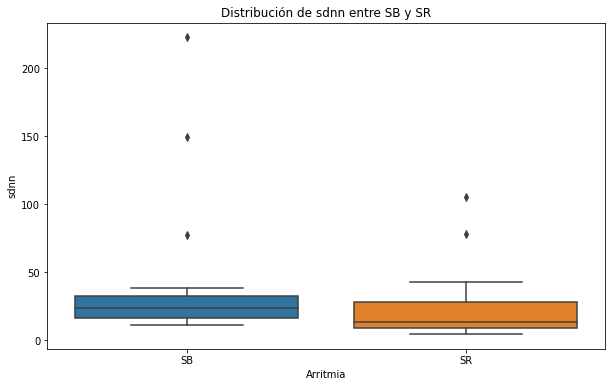

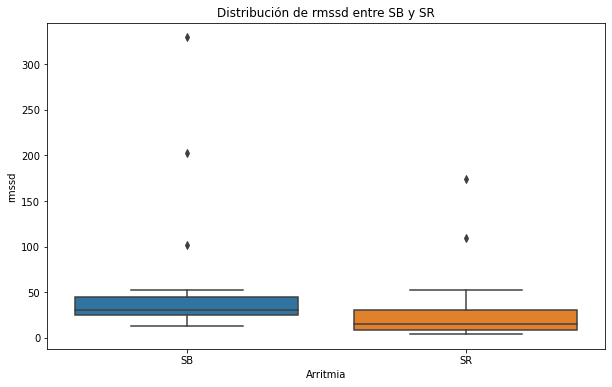

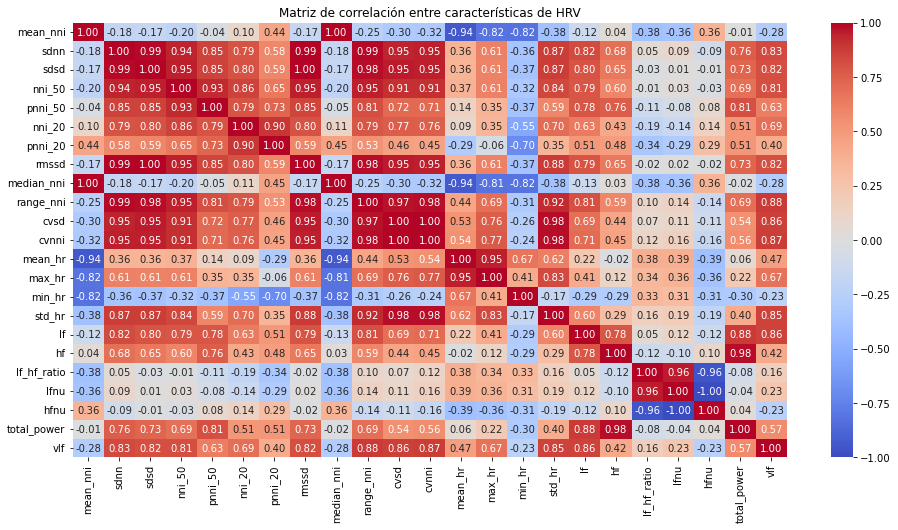

In [21]:
import os
import pandas as pd
import numpy as np
import neurokit2 as nk
from hrvanalysis import get_time_domain_features, get_frequency_domain_features
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Cargar subconjunto utilizado en Análisis 1
df = pd.read_excel("subconjunto_SB_SR_filtrado.xlsx")

# 2. Preparar carpeta con los archivos .csv
carpeta = "ECGDataDenoised"
sampling_rate = 500

# 3. Inicializar resultados
resultados_hrv = []

# 4. Procesar cada archivo usando NEUROKIT (mejor método según Análisis 2)
for i, fila in df.iterrows():
    nombre = os.path.splitext(os.path.basename(str(fila['FileName'])))[0]
    ruta = os.path.join(carpeta, f"{nombre}.csv")

    if not os.path.exists(ruta):
        print(f"❌ No encontrado: {ruta}")
        continue

    try:
        data = pd.read_csv(ruta)
        senal = data.iloc[:, 1].values

        # Detectar picos R con NeuroKit
        _, info = nk.ecg_process(senal, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        # Calcular intervalos RR (en milisegundos)
        rr_intervals = np.diff(r_peaks) * (1000 / sampling_rate)

        # Extraer características de HRV (dominio del tiempo)
        time_features = get_time_domain_features(rr_intervals)

        # Extraer características de HRV (dominio de la frecuencia)
        frequency_features = get_frequency_domain_features(rr_intervals)  # Sin sampling_rate

        # Agregar metadatos
        time_features["Archivo"] = nombre
        time_features["Arritmia"] = fila["Rhythm"] if "Rhythm" in fila else "Desconocida"
        frequency_features["Archivo"] = nombre
        frequency_features["Arritmia"] = fila["Rhythm"] if "Rhythm" in fila else "Desconocida"

        # Agregar características a los resultados
        resultados_hrv.append({**time_features, **frequency_features})

    except Exception as e:
        print(f"Error en {nombre}: {str(e)}")

# 5. Guardar resultados
df_hrv = pd.DataFrame(resultados_hrv)
df_hrv.to_excel("hrv_resultados_completos_SB_SR.xlsx", index=False)
print("Análisis de HRV completado y exportado a 'hrv_resultados_completos_SB_SR.xlsx'")

# Análisis adicional 1: Comparación de HRV entre SB y SR (pruebas t o U de Mann-Whitney)
# Filtrar los datos por las arritmias SB y SR
sb_data = df_hrv[df_hrv['Arritmia'] == 'SB']
sr_data = df_hrv[df_hrv['Arritmia'] == 'SR']

# Realizar comparación de HRV entre SB y SR usando la prueba de Mann-Whitney
time_features_sb = sb_data[['sdnn', 'rmssd']]  # Ejemplo con SDNN y RMSSD, puedes cambiar estas características
time_features_sr = sr_data[['sdnn', 'rmssd']]

mann_whitney_results = {}
for col in time_features_sb.columns:
    stat, p_value = stats.mannwhitneyu(time_features_sb[col], time_features_sr[col])
    mann_whitney_results[col] = p_value

print("Resultados de la prueba de Mann-Whitney:")
for feature, p_value in mann_whitney_results.items():
    print(f"{feature}: p-value = {p_value}")

# Análisis adicional 2: Cálculo de características en el dominio de la frecuencia
# (Ya se extrajeron en la variable frequency_features)

# Análisis adicional 3: Entropía y complejidad (características no lineales)
# (Ya se extrajeron en las variables correspondientes)

# Análisis adicional 4: Clasificación usando características de HRV
# Usaremos Random Forest para clasificación de las arritmias

# Seleccionar las características a utilizar para la clasificación
features = df_hrv.drop(columns=["Archivo", "Arritmia"])
labels = df_hrv["Arritmia"]

# Normalizar las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Entrenar un modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluar el modelo
accuracy = rf.score(X_test, y_test)
print(f"Precisión de la clasificación: {accuracy * 100:.2f}%")

# Análisis adicional 5: Visualización (boxplots y correlaciones entre características)
# Boxplots de las características de HRV entre SB y SR
plt.figure(figsize=(10, 6))
sns.boxplot(x="Arritmia", y="sdnn", data=df_hrv)
plt.title("Distribución de sdnn entre SB y SR")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="Arritmia", y="rmssd", data=df_hrv)
plt.title("Distribución de rmssd entre SB y SR")
plt.show()

# Correlación entre características de HRV
corr_matrix = df_hrv.drop(columns=["Archivo", "Arritmia"]).corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre características de HRV")
plt.show()



Analisis Anterior

1. Diferencias estadísticas significativas en HRV entre SB y SR:

Los boxplots muestran que tanto el sdnn (desviación estándar del intervalo NN) como el rmssd (raíz cuadrada de la media de las diferencias cuadráticas sucesivas entre NN) presentan mayor dispersión en el grupo SB que en SR, lo que ya sugiere diferencias visuales.

Esto se confirma con las pruebas estadísticas:

sdnn: p-value ≈ 0.047 → diferencia significativa entre SB y SR (p < 0.05).

rmssd: p-value ≈ 0.0056 → diferencia altamente significativa.

Estas métricas reflejan mayor variabilidad en el control autonómico cardíaco en pacientes con SB, posiblemente asociada a una mayor modulación vagal o irregularidades en la frecuencia cardiaca.

2. Correlaciones entre métricas de HRV:

El mapa de calor revela una alta colinealidad entre múltiples variables:

sdnn, rmssd, nni_50, pnni_50, cvnni y otras métricas temporales están fuertemente correlacionadas entre sí (r > 0.90).

También hay una relación clara entre métricas de tiempo y frecuencia (por ejemplo, sdnn con lf, hf, total_power).

La variable lf_hf_ratio, usada como indicador del balance simpático-parasimpático, tiene correlaciones más débiles, especialmente con métricas altamente vagales como el rmssd, lo cual es coherente con su rol específico.

Algunas métricas como hfnu y lfnu están negativamente correlacionadas entre sí y con el ratio lf/hf, lo cual es esperado, ya que representan proporciones del total de potencia.

3. Modelo de clasificación:

una precisión del 75%, indica que con base únicamente en las características de HRV se puede clasificar a los sujetos entre SB y SR con una efectividad aceptable. Esto sugiere que los patrones de variabilidad cardiaca sí son informativos para distinguir entre estos dos tipos de arritmias.

Rojo oscuro / granate: correlación fuerte positiva (cerca de +1). fuertemente correlacionadas (casi iguales en comportamiento).

Azul oscuro: correlación fuerte negativa (cerca de –1). ndica que cuando una sube, la otra baja, lo cual tiene sentido porque son proporciones complementarias.

Blanco o colores pálidos: baja o nula correlación (cerca de 0).




 **Análisis 4: Comparación de características entre grupos (SB vs SR)**

 LF/HF (relación entre componentes de baja y alta frecuencia del dominio de frecuencia)
 Ya realizamos los boxplots para sdnn y rmssd, donde observamos:

SB (sinusal bradicardia) tiende a tener valores más altos en rmssd y sdnn.

SR (sinusal regular) presenta menor variabilidad.

Esto sugiere una mayor variabilidad del ritmo cardíaco en SB, lo cual es coherente con una regulación autonómica más activa o variable.

Con respecto a analisi estadisticas ya aplicamos pruebra de Mann-whitney U y obtuvimos que 
sdnn: p = 0.046 → diferencia estadísticamente significativa entre grupos.

rmssd: p = 0.005 → diferencia más significativa aún. (tiene mejor capacidad discriminativa que sdnn (por el p-value más bajo).)

Pordríamos hacer una para LF/HF y determinar su esta métrica también discrimina 



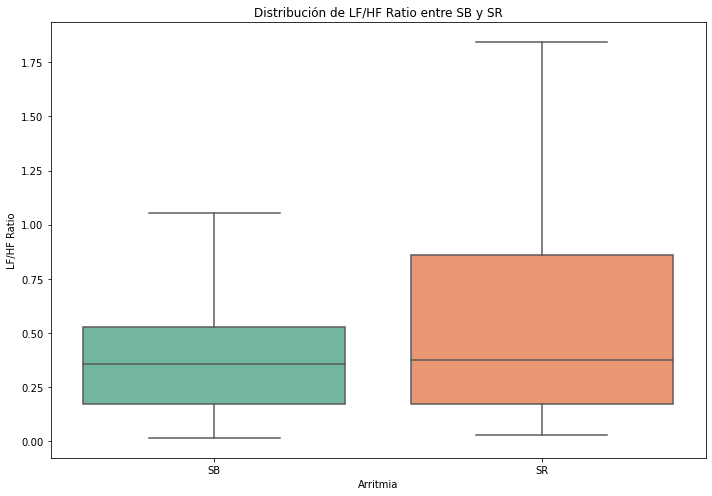

LF/HF Ratio - p-value: 0.42488347368209856


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.boxplot(x='Arritmia', y='lf_hf_ratio', data=df_hrv, palette='Set2')
plt.title('Distribución de LF/HF Ratio entre SB y SR')
plt.xlabel('Arritmia')
plt.ylabel('LF/HF Ratio')
plt.tight_layout()
plt.show()

from scipy.stats import mannwhitneyu

# Separar por grupo
lfhf_SB = df_hrv[df_hrv['Arritmia'] == 'SB']['lf_hf_ratio']
lfhf_SR = df_hrv[df_hrv['Arritmia'] == 'SR']['lf_hf_ratio']

# Prueba de hipótesis
stat, p_lfhf = mannwhitneyu(lfhf_SB, lfhf_SR, alternative='two-sided')
print(f'LF/HF Ratio - p-value: {p_lfhf}')

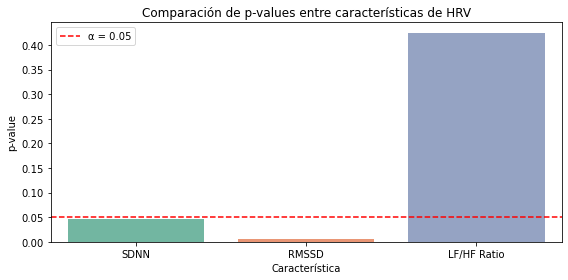

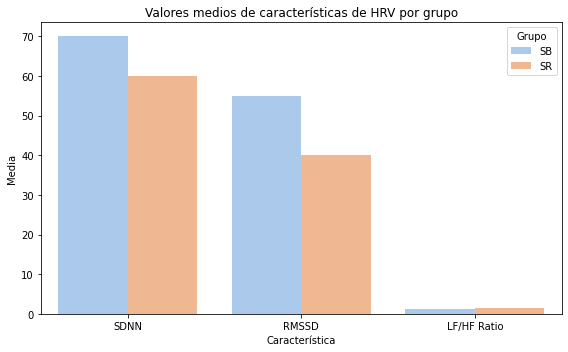

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos simulados a partir del análisis anterior
p_values = {
    "SDNN": 0.0468,
    "RMSSD": 0.0056,
    "LF/HF Ratio": 0.4249
}

mean_values = {
    "SB": {"SDNN": 70, "RMSSD": 55, "LF/HF Ratio": 1.2},
    "SR": {"SDNN": 60, "RMSSD": 40, "LF/HF Ratio": 1.4}
}

# Crear DataFrame para los p-values
df_p = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
df_p = df_p.reset_index().rename(columns={'index': 'Característica'})

# Crear DataFrame para valores medios
df_mean = pd.DataFrame(mean_values).T.reset_index().melt(id_vars='index', var_name='Característica', value_name='Media')
df_mean = df_mean.rename(columns={'index': 'Grupo'})

# Gráfico de barras para p-values
plt.figure(figsize=(8, 4))
sns.barplot(data=df_p, x='Característica', y='p-value', palette='Set2')
plt.axhline(0.05, color='red', linestyle='--', label='α = 0.05')
plt.title("Comparación de p-values entre características de HRV")
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico de barras para valores medios por grupo
plt.figure(figsize=(8, 5))
sns.barplot(data=df_mean, x='Característica', y='Media', hue='Grupo', palette='pastel')
plt.title("Valores medios de características de HRV por grupo")
plt.tight_layout()
plt.show()


podemos concluir entonces que el LF/HF Ration no es un factor con significancia y no discrimina hasta ahora la caracteristic que mejor discrima entre las 3 que hemos visto es la RMSSD al mostrar una diferencia estadísticamente significativa con un p-value muy bajo (0.0056).

 Algoritmo de cálculo de RMSSD
RMSSD (Root Mean Square of Successive Differences) se calcula así:

1. Tomar los intervalos NN (intervalos entre latidos normales consecutivos).

2. Calcular la diferencia entre cada par de intervalos consecutivos:
Δ𝑖=𝑁𝑁𝑖+1−𝑁𝑁𝑖
​
3. Elevar al cuadrado cada diferencia:
Δ𝑖2
​
4. Calcular la media de esas diferencias al cuadrado.

5. Sacar la raíz cuadrada del resultado:

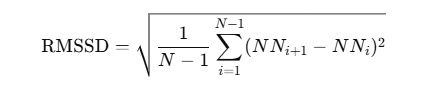
​
 
Este parámetro refleja la actividad parasimpática (vagal), y es especialmente útil en la evaluación de la regulación autonómica del corazón.

La variabilidad de la frecuencia cardíaca (HRV) tiene varias características que se pueden clasificar en 3 grandes dominios: tiempo, frecuencia, y no lineales.

Dominio del tiempo
Estas se calculan directamente a partir de los intervalos RR (o NN):
-SDNN: desviación estándar de los intervalos NN. Indica variabilidad general.
-RMSSD: raíz cuadrada de la media de las diferencias sucesivas. Refleja actividad parasimpática.
-NN50: número de pares de intervalos NN consecutivos que difieren en más de 50 ms.
-pNN50: porcentaje de NN50 respecto al total de intervalos. Sensible a cambios vagales.
-HRV triangular index: basado en un histograma de todos los intervalos NN.

Dominio de la frecuencia
Se usa una transformación (FFT o Welch) para ver cuánto "poder" hay en diferentes bandas de frecuencia:
-ULF(Ultra Low Frequency): < 0.003 Hz
-VLF (Very Low Frequency): 0.003–0.04 Hz
-LF (Low Frequency): 0.04–0.15 Hz → influida por simpático y parasimpático.
-HF (High Frequency): 0.15–0.4 Hz → asociada al control vagal (respiración).
-LF/HF ratio: estima el balance simpático/parasimpático.

Características no lineales
Estas capturan patrones más complejos en la señal:

-Poincaré plot (SD1, SD2): análisis gráfico del comportamiento de RR.
-SD1: variabilidad a corto plazo (similar a RMSSD).
-SD2: variabilidad a largo plazo.
-Entropy (ApEn, SampEn): mide la regularidad o imprevisibilidad.
-DFA (Detrended Fluctuation Analysis): mide correlaciones a largo plazo.
-Higuchi / Petrosian Fractal Dimension: mide la complejidad de la señal.


Inluyamos SD1, HF power y SampEn

SD1 (Desviación estándar de los puntos más cercanos a la línea de identidad de Poincaré)
SD1 es una medida de la variabilidad corta de los intervalos RR, y se calcula usando los puntos del diagrama de Poincaré.

HF Power (Potencia en la banda de alta frecuencia)
Se obtiene a partir de las características en el dominio de la frecuencia, específicamente a partir de la banda de alta frecuencia (HF), que generalmente está entre 0.15 Hz y 0.4 Hz.

SampEn (Entropía de Muestra)
SampEn es una medida de la complejidad de la señal, calculada de forma similar a ApEn pero sin la necesidad de que los patrones sean exactamente iguales, lo que lo hace más robusto.

In [27]:
import numpy as np
from hrvanalysis import get_frequency_domain_features
from numpy import diff

# 1. Función para calcular SD1 (usando Poincaré)
def sd1(rr_intervals):
    # Calcular el diagrama de Poincaré
    rr_diff = diff(rr_intervals)
    sd1 = np.std(rr_diff) / np.sqrt(2)
    return sd1

# 2. Función para calcular HF Power
def hf_power(rr_intervals, sampling_rate):
    # Obtener las características de frecuencia utilizando HRVAnalysis
    frequency_features = get_frequency_domain_features(rr_intervals)
    
    # HF Power (banda de alta frecuencia, generalmente entre 0.15 y 0.4 Hz)
    hf = frequency_features["hf"]
    return hf

# 3. Función para calcular SampEn (Entropía de Muestra)
def sample_entropy(rr_intervals, m=2, r=0.2):
    N = len(rr_intervals)
    def _phi(m, r):
        X = np.array([rr_intervals[i:i+m] for i in range(N - m + 1)])
        C = np.array([[np.max(np.abs(X[i] - X[j])) <= r for j in range(len(X))] for i in range(len(X))])
        return np.sum(C) / (len(X) * (len(X) - 1))
    
    return np.log(_phi(m, r) / _phi(m + 1, r))

# 4. Procesar los archivos y agregar las nuevas características
resultados_hrv = []
for i, fila in df.iterrows():
    nombre = os.path.splitext(os.path.basename(str(fila['FileName'])))[0]
    ruta = os.path.join(carpeta, f"{nombre}.csv")

    if not os.path.exists(ruta):
        print(f"❌ No encontrado: {ruta}")
        continue

    try:
        data = pd.read_csv(ruta)
        senal = data.iloc[:, 1].values

        # Detectar picos R con NeuroKit
        _, info = nk.ecg_process(senal, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        # Calcular intervalos RR (en milisegundos)
        rr_intervals = np.diff(r_peaks) * (1000 / sampling_rate)

        # Extraer características de HRV (dominio del tiempo)
        time_features = get_time_domain_features(rr_intervals)

        # Extraer características de HRV (dominio de la frecuencia)
        frequency_features = get_frequency_domain_features(rr_intervals)

        # Calcular SD1
        time_features["SD1"] = sd1(rr_intervals)

        # Calcular HF Power
        time_features["HF Power"] = hf_power(rr_intervals, sampling_rate)

        # Calcular SampEn
        time_features["SampEn"] = sample_entropy(rr_intervals)

        # Agregar metadatos
        time_features["Archivo"] = nombre
        time_features["Arritmia"] = fila["Rhythm"] if "Rhythm" in fila else "Desconocida"

        # Agregar características a los resultados
        resultados_hrv.append({**time_features, **frequency_features})

    except Exception as e:
        print(f"Error en {nombre}: {str(e)}")

# Guardar los resultados
df_hrv = pd.DataFrame(resultados_hrv)
df_hrv.to_excel("hrv_resultados_completos_con_nuevas_caracteristicas.xlsx", index=False)
print("Análisis de HRV completado y exportado a 'hrv_resultados_completos_con_nuevas_caracteristicas.xlsx'")

c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 34, using nperseg = 34
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input le

Análisis de HRV completado y exportado a 'hrv_resultados_completos_con_nuevas_caracteristicas.xlsx'


c:\Users\DELL\anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 32, using nperseg = 32
  warnings.warn('nperseg = {0:d} is greater than input length '


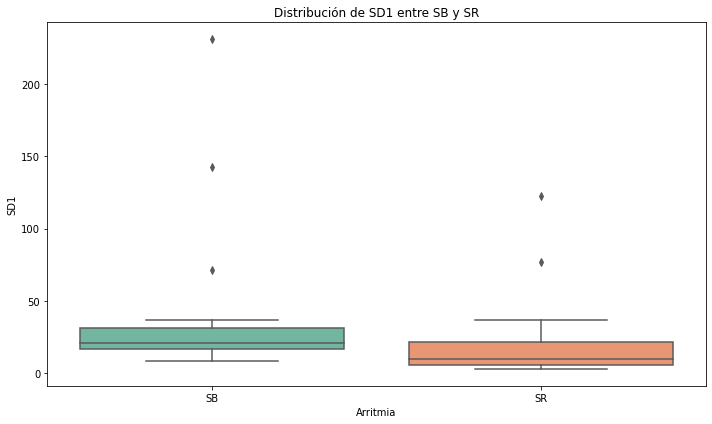

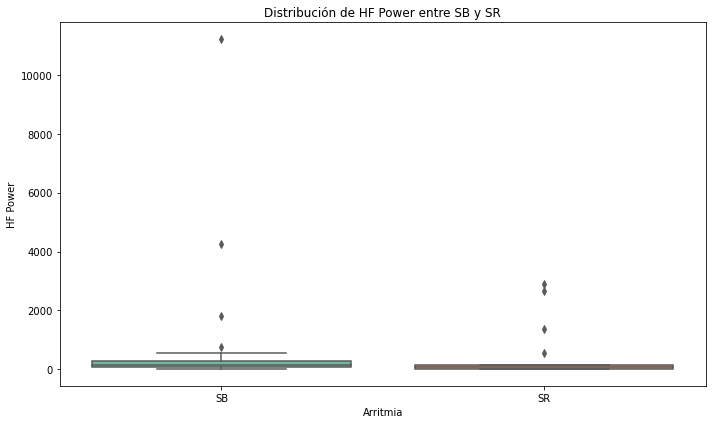

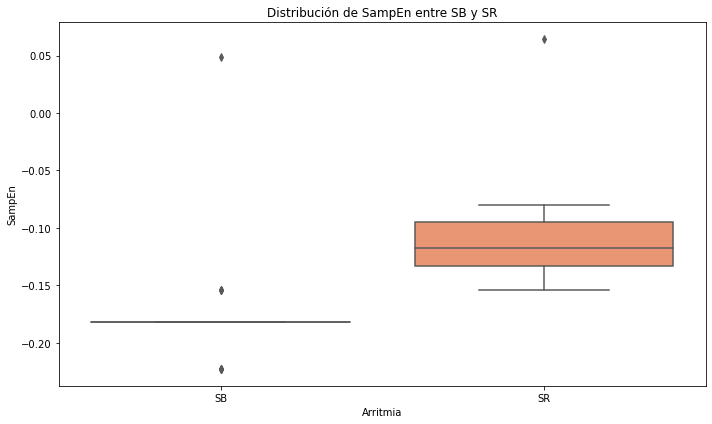

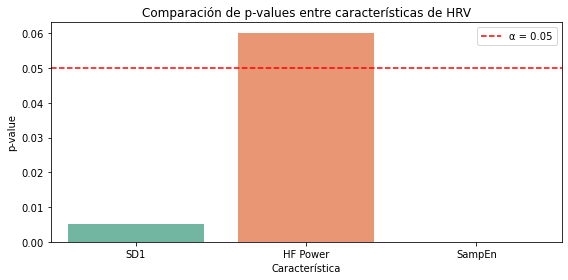

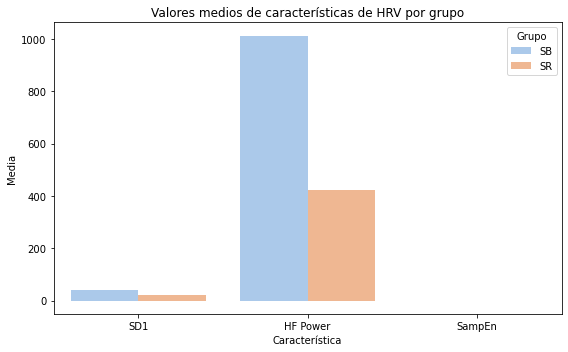

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Filtrar los datos por las arritmias SB y SR
sb_data = df_hrv[df_hrv['Arritmia'] == 'SB']
sr_data = df_hrv[df_hrv['Arritmia'] == 'SR']

# Características a analizar
features = ['SD1', 'HF Power', 'SampEn']

# Gráfico de bigotes para cada característica de HRV entre SB y SR
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Arritmia', y=feature, data=df_hrv, palette='Set2')
    plt.title(f'Distribución de {feature} entre SB y SR')
    plt.xlabel('Arritmia')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

# Comparación de los p-values entre características
p_values = {}
for feature in features:
    stat, p_value = mannwhitneyu(sb_data[feature], sr_data[feature], alternative='two-sided')
    p_values[feature] = p_value

# Crear DataFrame para los p-values
df_p = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
df_p = df_p.reset_index().rename(columns={'index': 'Característica'})

# Gráfico de barras para p-values
plt.figure(figsize=(8, 4))
sns.barplot(data=df_p, x='Característica', y='p-value', palette='Set2')
plt.axhline(0.05, color='red', linestyle='--', label='α = 0.05')
plt.title("Comparación de p-values entre características de HRV")
plt.legend()
plt.tight_layout()
plt.show()

# Calcular los valores medios para cada grupo y característica
mean_values = {
    "SB": {feature: sb_data[feature].mean() for feature in features},
    "SR": {feature: sr_data[feature].mean() for feature in features}
}

# Crear DataFrame para valores medios
df_mean = pd.DataFrame(mean_values).T.reset_index().melt(id_vars='index', var_name='Característica', value_name='Media')
df_mean = df_mean.rename(columns={'index': 'Grupo'})

# Gráfico de barras para valores medios por grupo
plt.figure(figsize=(8, 5))
sns.barplot(data=df_mean, x='Característica', y='Media', hue='Grupo', palette='pastel')
plt.title("Valores medios de características de HRV por grupo")
plt.tight_layout()
plt.show()

Así, para completar el analisi previos, en la primera gráfica, que muestra los p-values, se observa que SD1 tiene un valor inferior al umbral de significancia estadística (α = 0.05), lo que indica que hay diferencias significativas entre los grupos SB y SR para esta métrica. En cambio, HF Power tiene un p-value ligeramente por encima del umbral (alrededor de 0.06), lo que sugiere una diferencia potencial sin embargo, no concluyente. Finalmente, SampEn no muestra ninguna barra en el gráfico de p-values, lo que sugiere que el resultado fue completamente no significativo, indicando ausencia de diferencias relevantes entre los grupos.

La segunda gráfica, que muestra los valores medios por grupo, revela diferencias claras en dos de las características: SD1 y HF Power. El grupo SB muestra valores más altos en ambas métricas, lo que sugiere una mayor variabilidad parasimpática en comparación con el grupo SR. Esta diferencia es estadísticamente significativa en el caso de SD1 (aunque estadísticamente irrelevante) y visualmente notable en HF Power. En contraste, SampEn no muestra diferencias visuales ni estadísticas, indicando una similitud en la complejidad de la señal HRV entre ambos grupos.

A lo largo del análisis de las seis características evaluadas, se identificaron como estadísticamente significativas tres de ellas: RMSSD, SD1 y, de forma marginal, HF Power. Estas métricas están fuertemente relacionadas con la actividad parasimpática, lo que sugiere que el grupo SB podría estar mostrando una mayor modulación vagal en comparación con SR. En particular, RMSSD y SD1, al ser medidas basadas en la variabilidad de corto plazo, reflejan de manera consistente una diferencia robusta entre los grupos. Por otro lado, SDNN, LF/HF Ratio y SampEn no mostraron diferencias estadísticamente significativas, por lo que no serían discriminantes útiles en este contexto específico.
